In [ ]:
import os
from pathlib import Path

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def extract_frames_and_measure_blur(video_path, sample_rate=1, max_frames=None):
    """
    Extract frames from video and measure blur for each frame.

    Args:
        video_path: Path to the video file
        sample_rate: Extract every nth frame (1 = every frame, 2 = every 2nd frame, etc.)
        max_frames: Maximum number of frames to process (None = all frames)

    Returns:
        tuple: (frame_numbers, blur_scores, fps, total_frames)
    """
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise ValueError(f"Error: Could not open video file {video_path}")

    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / fps

    print(f"Video properties:")
    print(f"  FPS: {fps:.2f}")
    print(f"  Total frames: {total_frames}")
    print(f"  Duration: {duration:.2f} seconds")
    print(f"  Sample rate: every {sample_rate} frame(s)")

    frame_numbers = []
    blur_scores = []
    timestamps = []

    frame_count = 0
    processed_count = 0

    frames_to_process = total_frames // sample_rate
    if max_frames:
        frames_to_process = min(frames_to_process, max_frames)

    print(f"Processing approximately {frames_to_process} frames...")

    pbar = tqdm(total=frames_to_process, desc="Processing frames")
    while True:
        ret, frame = cap.read()

        if not ret:
            break

        # process every nth frame based on sample_rate
        if frame_count % sample_rate == 0:
            grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            laplacian_var = cv2.Laplacian(grey, cv2.CV_64F).var()  # calculate Laplacian variance (blur measurement)
            frame_numbers.append(frame_count)
            blur_scores.append(laplacian_var)
            timestamps.append(frame_count / fps)

            processed_count += 1
            pbar.update(1)

            if max_frames and processed_count >= max_frames:
                break

        frame_count += 1

    pbar.close()
    cap.release()

    print(f"Processed {len(blur_scores)} frames")

    return frame_numbers, blur_scores, timestamps, fps, total_frames

In [ ]:
def classify_blur_batch(blur_scores):
    """Classify blur levels for batch of scores."""
    classifications = []
    for score in blur_scores:
        if score < 100:
            classifications.append("Very blurry")
        elif score < 300:
            classifications.append("Blurry")
        elif score < 1000:
            classifications.append("Acceptable")
        else:
            classifications.append("Sharp")
    return classifications

In [ ]:
def plot_blur_analysis(frame_numbers, blur_scores, timestamps, fps, save_path=None):
    """
    Create comprehensive blur analysis plots.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Video Blur Analysis', fontsize=16, fontweight='bold')

    # Plot 1: Blur score over frame number
    axes[0, 0].plot(frame_numbers, blur_scores, 'b-', linewidth=1, alpha=0.7)
    axes[0, 0].set_xlabel('Frame Number')
    axes[0, 0].set_ylabel('Laplacian Variance (Blur Score)')
    axes[0, 0].set_title('Blur Score vs Frame Number')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=100, color='r', linestyle='--', alpha=0.5, label='Very blurry threshold')
    axes[0, 0].axhline(y=300, color='orange', linestyle='--', alpha=0.5, label='Blurry threshold')
    axes[0, 0].axhline(y=1000, color='g', linestyle='--', alpha=0.5, label='Sharp threshold')
    axes[0, 0].legend()

    # Plot 2: Blur score over time
    axes[0, 1].plot(timestamps, blur_scores, 'g-', linewidth=1, alpha=0.7)
    axes[0, 1].set_xlabel('Time (seconds)')
    axes[0, 1].set_ylabel('Laplacian Variance (Blur Score)')
    axes[0, 1].set_title('Blur Score vs Time')
    axes[0, 1].grid(True, alpha=0.3)

    # Plot 3: Histogram of blur scores
    axes[1, 0].hist(blur_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_xlabel('Laplacian Variance (Blur Score)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Blur Scores')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axvline(x=100, color='r', linestyle='--', alpha=0.7, label='Very blurry')
    axes[1, 0].axvline(x=300, color='orange', linestyle='--', alpha=0.7, label='Blurry')
    axes[1, 0].axvline(x=1000, color='g', linestyle='--', alpha=0.7, label='Sharp')
    axes[1, 0].legend()

    # Plot 4: Moving average
    window_size = min(50, len(blur_scores) // 10)
    if window_size > 1:
        moving_avg = pd.Series(blur_scores).rolling(window=window_size, center=True).mean()
        axes[1, 1].plot(timestamps, blur_scores, 'lightblue', alpha=0.5, label='Raw scores')
        axes[1, 1].plot(timestamps, moving_avg, 'darkblue', linewidth=2, label=f'Moving average ({window_size} frames)')
        axes[1, 1].set_xlabel('Time (seconds)')
        axes[1, 1].set_ylabel('Laplacian Variance (Blur Score)')
        axes[1, 1].set_title('Blur Trends (with Moving Average)')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()
    else:
        axes[1, 1].plot(timestamps, blur_scores, 'b-', linewidth=1)
        axes[1, 1].set_xlabel('Time (seconds)')
        axes[1, 1].set_ylabel('Laplacian Variance (Blur Score)')
        axes[1, 1].set_title('Blur Score vs Time')
        axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")

    plt.show()

In [ ]:
def print_blur_statistics(blur_scores, timestamps):
    """Print summary statistics of blur analysis."""
    blur_array = np.array(blur_scores)

    print("\n" + "="*50)
    print("BLUR ANALYSIS SUMMARY")
    print("="*50)

    print(f"Total frames analysed: {len(blur_scores)}")
    print(f"Video duration analysed: {timestamps[-1]:.2f} seconds")

    print(f"\nBlur Score Statistics:")
    print(f"  Mean: {np.mean(blur_array):.2f}")
    print(f"  Median: {np.median(blur_array):.2f}")
    print(f"  Standard deviation: {np.std(blur_array):.2f}")
    print(f"  Minimum: {np.min(blur_array):.2f}")
    print(f"  Maximum: {np.max(blur_array):.2f}")

    classifications = classify_blur_batch(blur_scores)
    unique, counts = np.unique(classifications, return_counts=True)

    print(f"\nFrame Quality Distribution:")
    for category, count in zip(unique, counts):
        percentage = (count / len(blur_scores)) * 100
        print(f"  {category}: {count} frames ({percentage:.1f}%)")

    min_idx = np.argmin(blur_array)
    max_idx = np.argmax(blur_array)

    print(f"\nExtreme Values:")
    print(f"  Blurriest moment: {timestamps[min_idx]:.2f}s (score: {blur_scores[min_idx]:.2f})")
    print(f"  Sharpest moment: {timestamps[max_idx]:.2f}s (score: {blur_scores[max_idx]:.2f})")

In [ ]:
# VIDEO_PATH = "/content/drive/MyDrive/nerf_studio/extracted_30s.mp4"
# SAVE_PLOT_PATH = "/content/drive/MyDrive/nerf_studio/blur_analysis_plot.png"

In [ ]:
# SAMPLE_RATE = 1        # extract every nth frame
# MAX_FRAMES = None      # maximum frames to process (None for all frames)

Processing video: /content/drive/MyDrive/nerf_studio/extracted_30s.mp4
Video properties:
  FPS: 29.97
  Total frames: 900
  Duration: 30.03 seconds
  Sample rate: every 1 frame(s)
Processing approximately 900 frames...


Processing frames: 100%|██████████| 900/900 [00:26<00:00, 34.36it/s]


Processed 900 frames

BLUR ANALYSIS SUMMARY
Total frames analysed: 900
Video duration analysed: 30.00 seconds

Blur Score Statistics:
  Mean: 299.55
  Median: 293.79
  Standard deviation: 76.46
  Minimum: 102.97
  Maximum: 594.71

Frame Quality Distribution:
  Acceptable: 424 frames (47.1%)
  Blurry: 476 frames (52.9%)

Extreme Values:
  Blurriest moment: 28.80s (score: 102.97)
  Sharpest moment: 17.72s (score: 594.71)
Plot saved to: /content/drive/MyDrive/nerf_studio/blur_analysis_plot.png


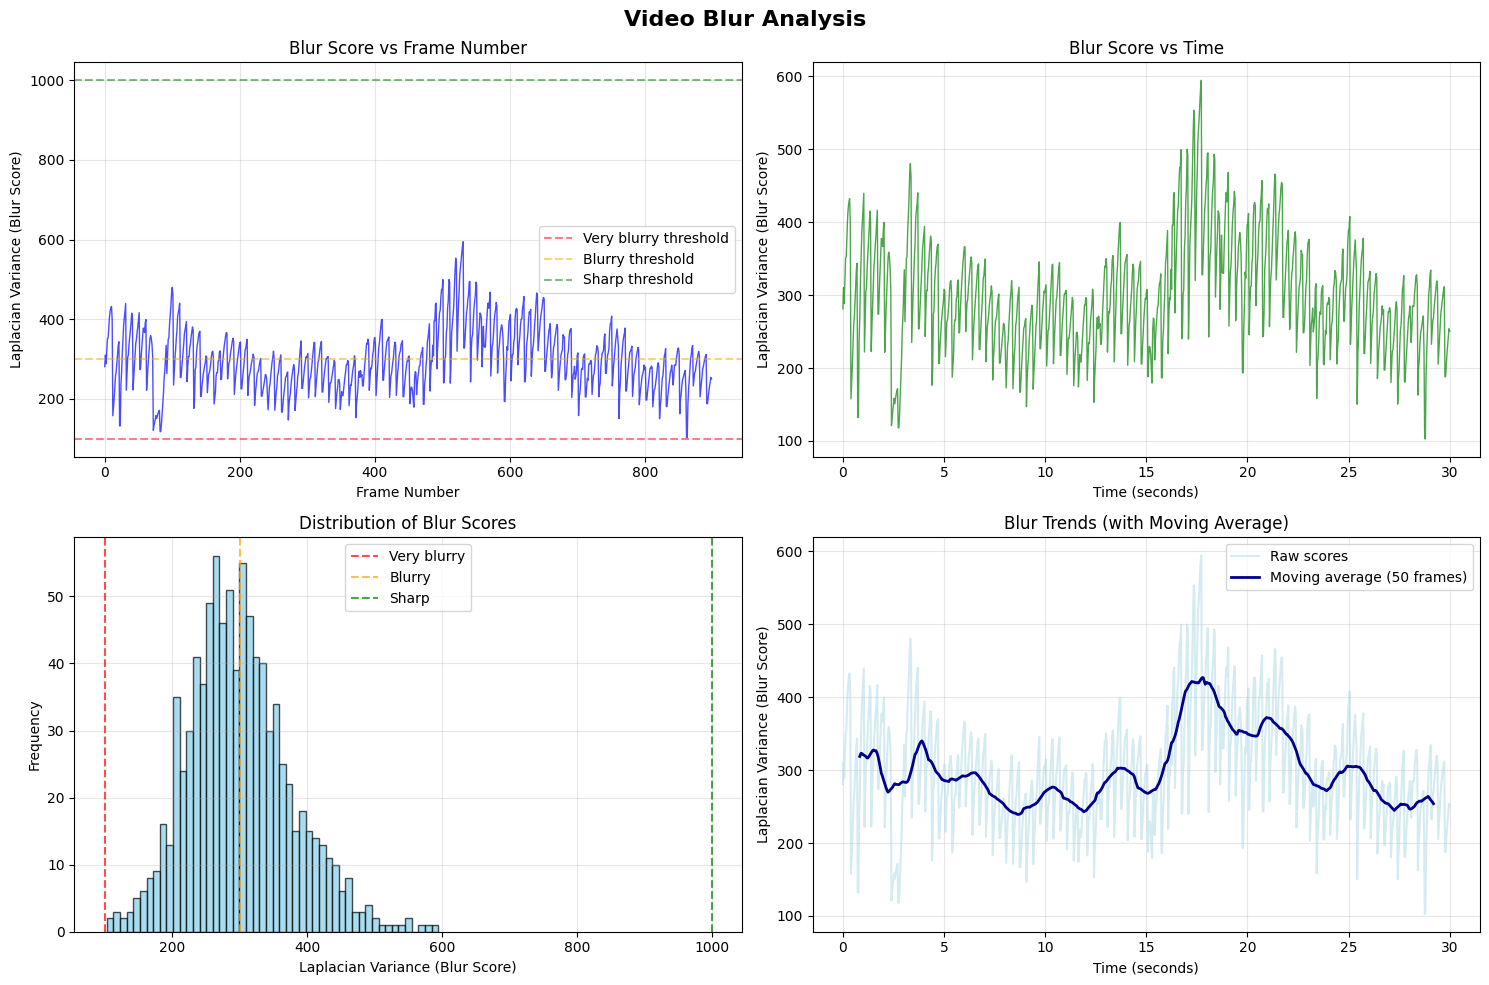

Data saved to: /content/drive/MyDrive/blur_analysis_data.csv

Analysis complete!


In [ ]:
# try:
#     if not os.path.exists(VIDEO_PATH):
#         print(f"Error: Video file not found at {VIDEO_PATH}")
#         print("Please update the VIDEO_PATH variable with the correct path to your video file.")

#     print(f"Processing video: {VIDEO_PATH}")

#     frame_numbers, blur_scores, timestamps, fps, total_frames = extract_frames_and_measure_blur(
#         VIDEO_PATH,
#         sample_rate=SAMPLE_RATE,
#         max_frames=MAX_FRAMES
#     )

#     print_blur_statistics(blur_scores, timestamps)
#     plot_blur_analysis(frame_numbers, blur_scores, timestamps, fps, SAVE_PLOT_PATH)
#     df = pd.DataFrame({
#         'frame_number': frame_numbers,
#         'timestamp_seconds': timestamps,
#         'blur_score': blur_scores,
#         'classification': classify_blur_batch(blur_scores)
#     })

#     csv_path = "/content/drive/MyDrive/blur_analysis_data.csv"
#     df.to_csv(csv_path, index=False)
#     print(f"Data saved to: {csv_path}")

#     print("\nAnalysis complete!")

# except Exception as e:
#     print(f"Error during processing: {str(e)}")
#     print("Please check your video path and ensure the file is accessible.")

In [ ]:
def enhance_image(image):
    """
    Enhance image to mitigate poor lighting and blur effects.

    Args:
        image: Input image as numpy array

    Returns:
        Enhanced image as numpy array
    """
    # bilateral filter to reduce noise while preserving edges
    denoised = cv2.bilateralFilter(image, 9, 75, 75)

    # convert to LAB colour space for better lighting control
    lab = cv2.cvtColor(denoised, cv2.COLOR_BGR2LAB)
    l_channel, a_channel, b_channel = cv2.split(lab)

    # apply CLAHE (Contrast Limited Adaptive Histogram Equalisation) to L channel
    # this improves local contrast and handles poor lighting
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_channel_clahe = clahe.apply(l_channel)

    # merge channels back and convert to BGR
    lab_enhanced = cv2.merge([l_channel_clahe, a_channel, b_channel])
    contrast_enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # sharpening to reduce blur effect
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])
    sharpened = cv2.filter2D(contrast_enhanced, -1, kernel)

    # blend original and sharpened (to avoid over-sharpening)
    # 70% sharpened + 30% contrast enhanced
    final_image = cv2.addWeighted(sharpened, 0.7, contrast_enhanced, 0.3, 0)

    # final gamma correction for better overall brightness
    # adjust gamma based on image brightness
    mean_brightness = np.mean(cv2.cvtColor(final_image, cv2.COLOR_BGR2GRAY))

    if mean_brightness < 100:  # dark image
        gamma = 1.2
    elif mean_brightness > 180:  # bright image
        gamma = 0.9
    else:  # normal image
        gamma = 1.0

    if gamma != 1.0:
        # lookup table for gamma correction
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        final_image = cv2.LUT(final_image, table)

    return final_image

In [ ]:
def enhance_images_in_directory(input_dir, output_dir):
    """
    Process all images in input directory and save enhanced versions to output directory.

    Args:
        input_dir: Path to directory containing input images
        output_dir: Path to directory where enhanced images will be saved
    """
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    supported_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif'}

    input_path = Path(input_dir)
    image_files = [f for f in input_path.iterdir()
                   if f.is_file() and f.suffix.lower() in supported_extensions]

    if not image_files:
        print(f"No supported image files found in {input_dir}")
        return

    print(f"Found {len(image_files)} images to process")
    print(f"Input directory: {input_dir}")
    print(f"Output directory: {output_dir}")

    for image_file in tqdm(image_files, desc="Enhancing images"):
        try:
            image_path = str(image_file)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read {image_file.name}")
                continue

            enhanced_image = enhance_image(image)
            output_filename = f"{image_file.stem}_enhanced{image_file.suffix}"
            output_path = Path(output_dir) / output_filename

            cv2.imwrite(str(output_path), enhanced_image)

        except Exception as e:
            print(f"Error processing {image_file.name}: {str(e)}")

    print(f"Enhancement complete! Enhanced images saved to: {output_dir}")

In [ ]:
def enhance_single_image(input_path, output_path):
    """
    Enhance a single image file.

    Args:
        input_path: Path to input image
        output_path: Path where enhanced image will be saved
    """
    image = cv2.imread(input_path)

    if image is None:
        raise ValueError(f"Could not read image from {input_path}")

    enhanced_image = enhance_image(image)
    Path(output_path).parent.mkdir(parents=True, exist_ok=True)
    cv2.imwrite(output_path, enhanced_image)

    print(f"Enhanced image saved to: {output_path}")

In [ ]:
enhance_images_in_directory(
    input_dir="/content/drive/MyDrive/nerf_studio/images",
    output_dir="/content/drive/MyDrive/nerf_studio/enhanced_frames"
)

Found 450 images to process
Input directory: /content/drive/MyDrive/nerf_studio/images
Output directory: /content/drive/MyDrive/nerf_studio/enhanced_frames


Enhancing images: 100%|██████████| 450/450 [03:14<00:00,  2.31it/s]

Enhancement complete! Enhanced images saved to: /content/drive/MyDrive/nerf_studio/enhanced_frames


In [ ]:
# enhance_single_image("blurry_image.jpg", "enhanced_image.jpg")